In [46]:
df = pd.read_csv('drive/MyDrive/Data/co2_mm_mlo.csv')

In [47]:
# !pip3 install pmdarima
# !pip3 uninstall statsmodels
# !pip3 install numpy scipy patsy pandas
# !pip3 install statsmodels


import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

from pmdarima import auto_arima                              # **for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [48]:
df

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00


In [49]:
df['date'] = pd.to_datetime({'year': df['year'] , 'month': df['month'], 'day': 1})

In [50]:
DF = df[['interpolated', 'date']]
DF.dropna(inplace=True)
DF.set_index('date', inplace=True)
DF.index.freq = 'MS'

In [51]:
DF.head()

,interpolated
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


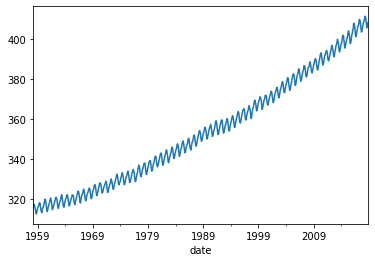

In [52]:
DF['interpolated'].plot()

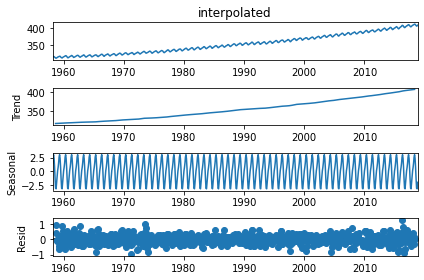

In [53]:
decomposed = seasonal_decompose(DF['interpolated'],model='add')
decomposed.plot();

In [ ]:
# help(auto_arima)

In [44]:
train = DF.iloc[:717]
test = DF.iloc[717:]

In [72]:
stepwise_fit = auto_arima(train['interpolated'], start_p = 0, start_q = 0, d= None, max_p = 5, max_q = 5, max_order=8,m=12, seasonal=True, stationary=False, information_criterion='aic',stepwise=True, suppress_warnings=True)

In [73]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.881
Date:                            Fri, 02 Apr 2021   AIC                            415.762
Time:                                    11:49:26   BIC                            443.205
Sample:                                         0   HQIC                           426.359
                                            - 717                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3481      0.047      7.435      0.000       0.256       0.440
ar.L2          0.0837      0.025      3.365      0.001       0.035       0.132
ma.L1         -0.7023      0.035    -19.838      0.000      -0.772      -0.633
ar.S.L12       0.9996      0.000   2911.034      0.000       0.999       1.000
ma.S.L12      -0.8657      0.023    -37.990      0.000      -0.910      -0.821
sigma2         0.0953      0.005     20.662      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.68
Prob(Q):                              0.80   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# (2, 1, 1)x(1, 0, 1, 12)
model = SARIMAX(train['interpolated'], order=(2,1,1), seasonal_order=(1,0,1,12))
fitted_model = model.fit()

In [75]:
# typ = levels beacuse we want actual predicted values and not differenced
start=len(train)
end=len(train)+len(test)-1
predictions = fitted_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,1,1)(1,0,1,12)')

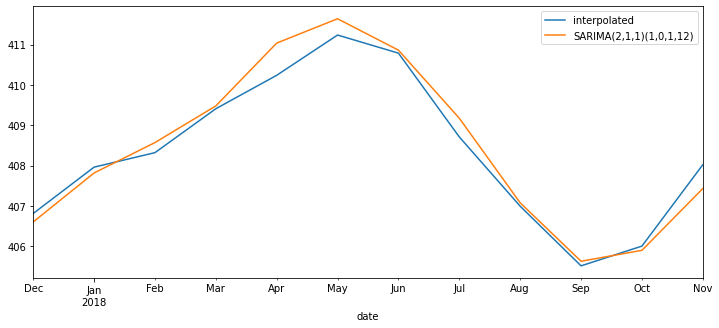

In [76]:
test.plot(figsize=(12,5), legend = True)
predictions.plot(figsize=(12,5), legend = True)

In [79]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA MSE Error: {error}')

SARIMA MSE Error: 0.1280811386213291


In [78]:
###Forecast

In [80]:
#Retrain Full model on full data and forecast
# (2,1,1)x(1, 0, 1, 12)
final_model = SARIMAX(DF['interpolated'], order=(2,1,1), seasonal_order=(1,0,1,12))
final_fitted_model = final_model.fit()

forecast = final_fitted_model.predict(start=len(DF), end=len(DF)+11, dynamic=False, typ='levels').rename('SARIMA(2,1,1)(1,0,1,12)')

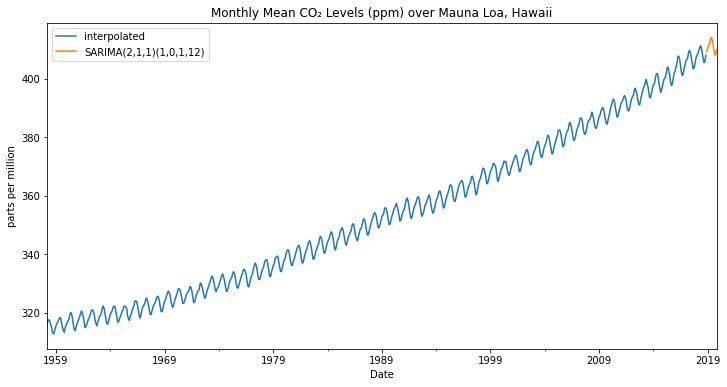

In [82]:
# Plot forecast
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'  
xlabel='Date'

ax = DF['interpolated'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);